In [1]:
import importlib
from osgeo import gdal
import pprint
import json
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# 0 => clear land pixel
# 1 => clear water pixel
# 2 => cloud shadow
# 3 => snow
# 4 => cloud

In [2]:
import os

directory = f"/Volumes/X/Data/fusion-s1-s2/s2/fmask/"  # replace with the path to your directory
fmask_paths = [
    f"/Volumes/X/Data/fusion-s1-s2/s2/fmask/" +
    folder_name +
    "/" +
    folder_name +
    "_fmask.tif"
    for folder_name in os.listdir(directory)
]

In [3]:
MAP_CLOUD = {
    0: "clear_land",
    1: "cloud_water", 
    2: "cloud_shadow",
    3: "snow",
    4: "cloud",
    255: "no_observation"
}

In [58]:
def fmask_double(input_path, output_path):
    if os.path.isfile(input_path):
        src_ds = gdal.Open(input_path)
    else:
        src_ds = gdal.Open("/".join(input_path.split("/")[:-1])+"/fmask.tif")

    # Calculate the new dimensions
    new_width = src_ds.RasterXSize * 2
    new_height = src_ds.RasterYSize * 2

    # Set up the warp options
    warp_options = gdal.WarpOptions(format="VRT",
                                    width=new_width,
                                    height=new_height,
                                    resampleAlg=gdal.GRA_Bilinear)
    
    gdal.Warp(destNameOrDestDS=output_path, srcDSOrSrcDSTab=src_ds, options=warp_options)

In [ ]:
for fmask_path in fmask_paths:
    file_name = "_".join(fmask_path.split("/")[-1].split("_")[:-1])
    output_path = f"data/fmask_cropped/{file_name}/{file_name}.vrt"
    if not os.path.exists(f"data/fmask_cropped/{file_name}/"):
                os.makedirs(f"data/fmask_cropped/{file_name}/")
    fmask_double(fmask_path, output_path)

In [60]:
CROP_SIZE = 256

In [108]:
for fmask in os.listdir("data/fmask_cropped/"):
    print(fmask)
    image_path = f"data/fmask_cropped/{fmask}/{fmask}.vrt"
    image = gdal.Open(image_path)
    print(f"Processing {image_path}")

    width = image.RasterXSize
    height = image.RasterYSize

    gt = image.GetGeoTransform()

    min_x = int(gt[0])
    min_y = int(gt[3]) - CROP_SIZE * 10
    max_x = int(gt[0] + width*gt[1])
    max_y = int(gt[3] + height*gt[5]) - CROP_SIZE * 10

    x_length = range(min_x, max_x + CROP_SIZE + 1, CROP_SIZE*10)
    y_length = range(min_y, max_y - CROP_SIZE + 1, -CROP_SIZE*10)

    ALL_XY_COORDINATES = [(x, y) for y in y_length for x in x_length]

    if not os.path.isdir(f"data/fmask_cropped/{fmask}/cropped/"):
        os.makedirs(f"data/fmask_cropped/{fmask}/cropped/")
    for idx, (x, y) in enumerate(ALL_XY_COORDINATES):
        vrt_options = gdal.BuildVRTOptions(resolution="highest", outputBounds=(x, y, x + CROP_SIZE * 10, y + CROP_SIZE * 10))
        gdal.BuildVRT(f"data/fmask_cropped/{fmask}/cropped/{fmask}_{idx}_{x}_{y}_{CROP_SIZE}.vrt", [image_path], options=vrt_options)

S2_32VNH_20200825
Processing data/fmask_cropped/S2_32VNH_20200825/S2_32VNH_20200825.vrt
S2_32VNH_20210429
Processing data/fmask_cropped/S2_32VNH_20210429/S2_32VNH_20210429.vrt
S2_32VNH_20190903
Processing data/fmask_cropped/S2_32VNH_20190903/S2_32VNH_20190903.vrt
S2_32VNH_20200214
Processing data/fmask_cropped/S2_32VNH_20200214/S2_32VNH_20200214.vrt
S2_32VNH_20191214
Processing data/fmask_cropped/S2_32VNH_20191214/S2_32VNH_20191214.vrt
S2_32VNH_20210624
Processing data/fmask_cropped/S2_32VNH_20210624/S2_32VNH_20210624.vrt
S2_32VNH_20200822
Processing data/fmask_cropped/S2_32VNH_20200822/S2_32VNH_20200822.vrt
S2_32VNH_20210623
Processing data/fmask_cropped/S2_32VNH_20210623/S2_32VNH_20210623.vrt
S2_32VNH_20191028
Processing data/fmask_cropped/S2_32VNH_20191028/S2_32VNH_20191028.vrt
S2_32VNH_20190131
Processing data/fmask_cropped/S2_32VNH_20190131/S2_32VNH_20190131.vrt
S2_32VNH_20210427
Processing data/fmask_cropped/S2_32VNH_20210427/S2_32VNH_20210427.vrt
S2_32VNH_20191017
Processing dat

In [109]:
json_data = {}

FMASK_DIRECTORY = f"data/fmask_cropped/"

for fmask_path in os.listdir(FMASK_DIRECTORY):
    print(f"Processing {fmask_path}")
    path_to_crops = f"{FMASK_DIRECTORY}{fmask_path}/cropped/"
    for im_path in os.listdir(path_to_crops):
        x, y = int(im_path.split("_")[-3]), int(im_path.split("_")[-2])
        gdal_data = gdal.Open(f"{FMASK_DIRECTORY}{fmask_path}/cropped/{im_path}")
        data = gdal_data.ReadAsArray()
        
        shape = data.size
        
        count = dict(Counter(itertools.chain(*data)))
        map = {MAP_CLOUD[k]: round((v/shape)*100, 2) for k, v in count.items()}
        
        json_data[im_path.split("/")[-1]] = dict(sorted(map.items(), key=lambda x: -x[1]))

with open("data/fmask_cropped_stats.json", "w") as f:
    json.dump(json_data, f)

Processing S2_32VNH_20200825
Processing S2_32VNH_20210429
Processing S2_32VNH_20190903
Processing S2_32VNH_20200214
Processing S2_32VNH_20191214
Processing S2_32VNH_20210624
Processing S2_32VNH_20200822
Processing S2_32VNH_20210623
Processing S2_32VNH_20191028
Processing S2_32VNH_20190131
Processing S2_32VNH_20210427
Processing S2_32VNH_20191017
Processing S2_32VNH_20200225
Processing S2_32VNH_20200813
Processing S2_32VNH_20200222
Processing S2_32VNH_20191222
Processing S2_32VNH_20191010
Processing S2_32VNH_20210420
Processing S2_32VNH_20190304
Processing S2_32VNH_20200420
Processing S2_32VNH_20190506
Processing S2_32VNH_20210813
Processing S2_32VNH_20190501
Processing S2_32VNH_20200427
Processing S2_32VNH_20190705
Processing S2_32VNH_20210213
Processing S2_32VNH_20200623
Processing S2_32VNH_20210822
Processing S2_32VNH_20190508
Processing S2_32VNH_20200624
Processing S2_32VNH_20210214
Processing S2_32VNH_20190702
Processing S2_32VNH_20190530
Processing S2_32VNH_20200429
Processing S2_

In [3]:
with open("data/fmask_cropped_stats.json", "r") as f:
    fmask_data = json.load(f)

In [4]:
fmask_data_filtered_no_observation = {}

for k, v in fmask_data.items():
    if "no_observation" not in v or v["no_observation"] < 1:
        fmask_data_filtered_no_observation[k] = v


In [5]:
fmask_data_filtered_no_observation

{'S2_32VNH_20200825_1537_581900_6207840_256.vrt': {'cloud_water': 91.99,
  'cloud': 7.28,
  'snow': 0.34,
  'cloud_shadow': 0.33,
  'clear_land': 0.05},
 'S2_32VNH_20200825_963_543500_6241120_256.vrt': {'clear_land': 87.89,
  'cloud': 9.85,
  'cloud_shadow': 0.99,
  'cloud_water': 0.7,
  'snow': 0.56},
 'S2_32VNH_20200825_1310_551180_6220640_256.vrt': {'cloud': 40.14,
  'clear_land': 38.1,
  'cloud_shadow': 17.21,
  'cloud_water': 2.34,
  'snow': 2.21},
 'S2_32VNH_20200825_1110_589580_6233440_256.vrt': {'cloud_water': 64.66,
  'clear_land': 19.91,
  'cloud_shadow': 9.78,
  'cloud': 5.2,
  'snow': 0.45},
 'S2_32VNH_20200825_1033_502540_6236000_256.vrt': {'cloud': 63.61,
  'cloud_shadow': 19.74,
  'clear_land': 12.79,
  'snow': 2.28,
  'cloud_water': 1.57},
 'S2_32VNH_20200825_256_604940_6284640_256.vrt': {'cloud_water': 100.0},
 'S2_32VNH_20200825_370_566540_6276960_256.vrt': {'cloud': 57.89,
  'cloud_shadow': 28.39,
  'clear_land': 9.38,
  'snow': 2.46,
  'cloud_water': 1.89},
 'S2_32V

In [6]:
cloudy_fmask_data = {}

for k, v in fmask_data_filtered_no_observation.items():
    if "cloud" in v and v["cloud"] > 20:
        cloudy_fmask_data[k] = v

In [7]:
cloud_free_fmask_data = {}

for k, v in fmask_data_filtered_no_observation.items():
    if "cloud" not in v or v["cloud"] < 1:
        cloud_free_fmask_data[k] = v

In [8]:
def find_closest_date_and_coordinates(target_date, target_x, target_y):
    target_date = datetime.strptime(target_date, "%Y%m%d")

    # Initialize the minimum difference and the result
    min_diff = None
    result = None

    for k, v in cloud_free_fmask_data.items():
        date, x, y = k.split("_")[2], k.split("_")[4], k.split("_")[5]
        if x == target_x and y == target_y:
            # Convert item date string to datetime object
            item_date = datetime.strptime(date, "%Y%m%d")

            # Calculate the time difference
            diff = abs(target_date - item_date)

            # Update the result if the difference is smaller than the current minimum
            if min_diff is None or diff < min_diff:
                min_diff = diff
                result = k
    if result:
        return result, min_diff

In [9]:
CANDIDATES_FMASK = {}
idx = 0
for k, v in cloudy_fmask_data.items():
    date, x, y = k.split("_")[2], k.split("_")[4], k.split("_")[5]
    if s:= find_closest_date_and_coordinates(date, x, y):
        if s[1] <= timedelta(days=10):
            CANDIDATES_FMASK[idx] = {
                "cloudy": k,
                "cloud_free": s[0] 
            }
            idx += 1


KeyboardInterrupt: 

In [10]:
CANDIDATES_FMASK

{0: {'cloudy': 'S2_32VNH_20200825_1310_551180_6220640_256.vrt',
  'cloud_free': 'S2_32VNH_20200817_1310_551180_6220640_256.vrt'},
 1: {'cloudy': 'S2_32VNH_20200825_1033_502540_6236000_256.vrt',
  'cloud_free': 'S2_32VNH_20200815_1033_502540_6236000_256.vrt'},
 2: {'cloudy': 'S2_32VNH_20200825_370_566540_6276960_256.vrt',
  'cloud_free': 'S2_32VNH_20200901_370_566540_6276960_256.vrt'},
 3: {'cloudy': 'S2_32VNH_20200825_1058_566540_6236000_256.vrt',
  'cloud_free': 'S2_32VNH_20200901_1058_566540_6236000_256.vrt'},
 4: {'cloudy': 'S2_32VNH_20200825_354_525580_6276960_256.vrt',
  'cloud_free': 'S2_32VNH_20200815_354_525580_6276960_256.vrt'},
 5: {'cloudy': 'S2_32VNH_20200825_1752_581900_6195040_256.vrt',
  'cloud_free': 'S2_32VNH_20200822_1752_581900_6195040_256.vrt'},
 6: {'cloudy': 'S2_32VNH_20200825_1428_523020_6212960_256.vrt',
  'cloud_free': 'S2_32VNH_20200817_1428_523020_6212960_256.vrt'},
 7: {'cloudy': 'S2_32VNH_20200825_1024_589580_6238560_256.vrt',
  'cloud_free': 'S2_32VNH_2020

In [11]:
with open("data/candidates.json", "w") as f:
    json.dump(CANDIDATES_FMASK, f)

In [68]:

def closest_date(target_date, date_array):
    target = datetime.strptime(target_date, '%Y%m%d')
    date_array = [d for d in date_array if d != "Store"]
    date_array = [datetime.strptime(date, '%Y%m%d') for date in date_array]
    closest_date = min(date_array, key=lambda x: abs(target - x))
    return closest_date.strftime('%Y%m%d')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


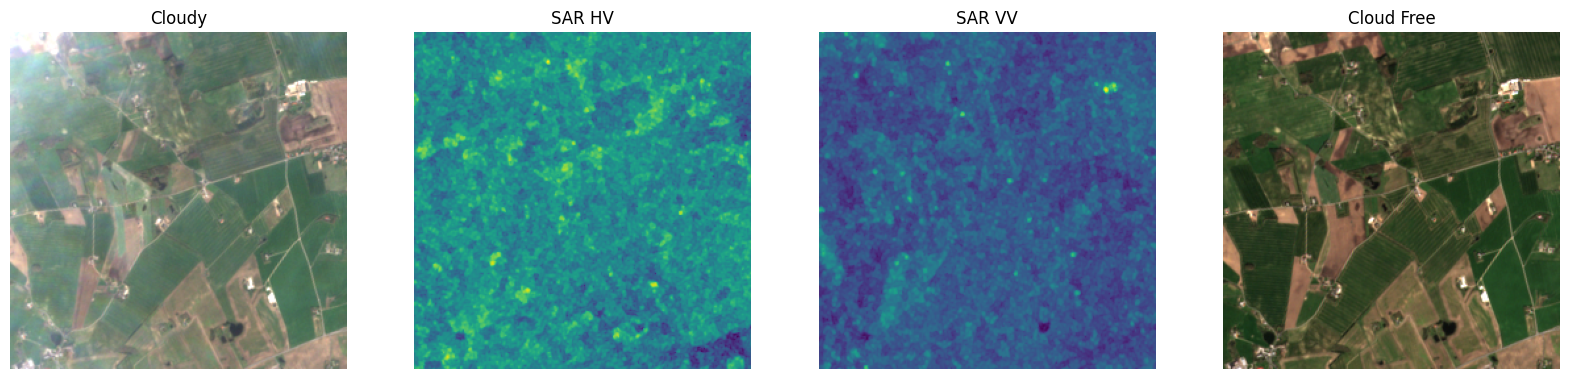

In [89]:
os.chdir("/Users/thomashebrard/thesis/code/preprocess")
with open("data/candidates.json", "r") as f:
    data = json.load(f)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))


# cloudy = "S2_32VNH_20190405_1191_576780_6228320_256"
cloudy = "S2_32VNH_20190405_873_533260_6246240_256"
# cloudy = "S2_32VNH_20190405_1211_517900_6225760_256"
# cloudy = "S2_32VNH_20190702_443_533260_6271840_256"
date_cloudy = "_".join(cloudy.split("_")[:3])
rest = "_".join(cloudy.split("_")[3:])

cloudy_B02 = gdal.Open(
    f"../project/pix2pix/data/cropped/s2/{date_cloudy}/{date_cloudy}_B02/{date_cloudy}_B02_{rest}.tif"
).ReadAsArray()

cloudy_B03 = gdal.Open(
    f"../project/pix2pix/data/cropped/s2/{date_cloudy}/{date_cloudy}_B03/{date_cloudy}_B03_{rest}.tif"
).ReadAsArray()

cloudy_B04 = gdal.Open(
    f"../project/pix2pix/data/cropped/s2/{date_cloudy}/{date_cloudy}_B04/{date_cloudy}_B04_{rest}.tif"
).ReadAsArray()

cloudy_data = np.stack((cloudy_B04, cloudy_B03, cloudy_B02), axis=-1)/2000



# cloud_free = "S2_32VNH_20190329_1191_576780_6228320_256"
cloud_free = "S2_32VNH_20190413_873_533260_6246240_256"
# cloud_free = "S2_32VNH_20190413_1211_517900_6225760_256"
# cloud_free = "S2_32VNH_20190629_443_533260_6271840_256"
date_cloud_free = "_".join(cloud_free.split("_")[:3])
rest = "_".join(cloud_free.split("_")[3:])

cloud_free_B02 = gdal.Open(
    f"../project/pix2pix/data/cropped/s2/{date_cloud_free}/{date_cloud_free}_B02/{date_cloud_free}_B02_{rest}.tif"
).ReadAsArray()

cloud_free_B03 = gdal.Open(
    f"../project/pix2pix/data/cropped/s2/{date_cloud_free}/{date_cloud_free}_B03/{date_cloud_free}_B03_{rest}.tif"
).ReadAsArray()

cloud_free_B04 = gdal.Open(
    f"../project/pix2pix/data/cropped/s2/{date_cloud_free}/{date_cloud_free}_B04/{date_cloud_free}_B04_{rest}.tif"
).ReadAsArray()

cloud_free_data = np.stack((cloud_free_B04, cloud_free_B03, cloud_free_B02), axis=-1)/2000

### ADDIND SAR DATA ###

s1_dates = [d.split("_")[-1] for d in os.listdir(f"../project/pix2pix/data/cropped/s1/")]
date_s1 = closest_date(date_cloudy.split("_")[-1], s1_dates)
y = int(rest.split("_")[-2]) - 1
rest = "_".join(rest.split("_")[:-2]) + "_" + str(y) + "_256"
os.chdir("../project/pix2pix/")
s1_HV = gdal.Open(f"data/cropped/s1/S1_32VNH_{date_s1}/S1_32VNH_{date_s1}_HV/S1_32VNH_{date_s1}_HV_{rest}.vrt").ReadAsArray()
s1_VV = gdal.Open(f"data/cropped/s1/S1_32VNH_{date_s1}/S1_32VNH_{date_s1}_VV/S1_32VNH_{date_s1}_VV_{rest}.vrt").ReadAsArray()

axes[0].imshow(cloudy_data)
axes[0].set_title('Cloudy')
axes[0].axis('off')  # Hide axes

# Display image2 in the second subplot
axes[1].imshow(s1_HV)
axes[1].set_title('SAR HV')
axes[1].axis('off')  # Hide axes

# Display image2 in the second subplot
axes[2].imshow(s1_VV)
axes[2].set_title('SAR VV')
axes[2].axis('off')  # Hide axes

# Display image2 in the second subplot
axes[3].imshow(cloud_free_data)
axes[3].set_title('Cloud Free')
axes[3].axis('off')  # Hide axes

# Show the plot
plt.show()
